In [1]:
import numpy as np;
import torch;
import sys;
sys.path.append('../lib')

import matplotlib.pyplot as plt;
import time;
import args;
import ising;
from VAN import VAN;
from generate_samples import generate_samples;

args.beta = 0.44;
args.L = 16;

In [2]:
#initialize the network (replace 'cuda' with 'cpu' if necessary)
net = VAN(args.L, 4, 64, 1, 'cuda').to('cuda');
net.load_state_dict(torch.load('example_VAN.pt', map_location='cuda'));

In [6]:
#generate samples
#if memory insufficient -> decrease N_sampling_batch
samples, energy, log_prob = generate_samples(net, 10**6, N_sampling_batch=10**4);
log_weight = -args.beta*energy*args.L**2 - log_prob;
log_weight -= np.mean(log_weight); #to prevent overflows
major_spin = 2 * (np.mean(samples) > 0) - 1;
log_weight_discard = log_weight.copy();
#assign zero weight to samples with a net magnetization that does not equal the prefered magnetization
#otherwise large statistical fluctuations
log_weight_discard[2 * (np.mean(samples, axis=(1,2)) > 0) - 1 != major_spin] = -1000;

In [7]:
#reference data
energy_exact = np.load('exact_data/e_hist_16_044.npz')['arr_0'];

/tmp/ipykernel_2068199/2398477437.py:11: RuntimeWarning: underflow encountered in exp
  ax[1].hist(energy, bins=80, color='blue', density=True, alpha=0.3, label='VAN', weights=np.exp(log_weight_discard), range=(-2,-0.75));


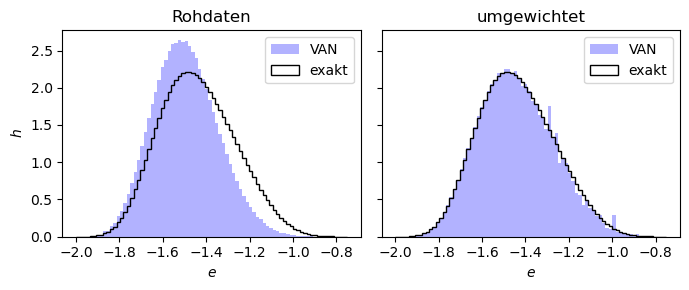

In [8]:
fig, ax = plt.subplots(1,2, sharex=True, sharey=True, figsize=(7, 3));

ax[0].hist(energy, bins=80, color='blue', density=True, alpha=0.3, label='VAN', range=(-2,-0.75));
ax[0].hist(energy_exact, density=True, color='k', histtype='step', bins=80, label='exakt', range=(-2,-0.75));
ax[0].legend();
ax[0].set_xlabel(r'$e$');
ax[0].set_ylabel(r'$h$');
ax[0].set_title('Rohdaten');

#ax[1].hist(energy, bins=80, color='blue', density=True, alpha=0.3, label='VAN', weights=np.exp(log_weight), range=(-2,-0.75));
ax[1].hist(energy, bins=80, color='blue', density=True, alpha=0.3, label='VAN', weights=np.exp(log_weight_discard), range=(-2,-0.75));
ax[1].hist(energy_exact, density=True, color='k', histtype='step', bins=80, label='exakt', range=(-2,-0.75));
ax[1].legend();
ax[1].set_xlabel(r'$e$');
ax[1].set_title('umgewichtet');

fig.tight_layout();